## Librerías

In [ ]:
import os
import pathlib
import shutil


import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import librosa
from IPython import display

from tensorflow.keras import layers
from tensorflow.keras import models

Establecer GPU por defecto en caso de estar disponible.

In [ ]:
# Configurar para que TensorFlow utilice la GPU por defecto
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Configurar para que TensorFlow asigne memoria dinámicamente
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    # Especificar la GPU por defecto
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Manejar error
    print(e)

1 Physical GPUs, 1 Logical GPUs


## Carga del Dataset

Repositorio del Dataset:

```
https://github.com/Jakobovski/free-spoken-digit-dataset/tree/master
```



Clonamos el repositorio para descargar el dataset de las grabaciones de audio que se encuentran en la carpeta `recordings`.

Ordenamos los archivos de audio separandolos en subcarpetas según su etiqueta.


Al estar divididos de esta forma, podemos cargar el dataset con `keras.utils.audio_dataset_from_directory`.



In [ ]:
# Clonamos el repo
repo_name = "free-spoken-digit-dataset"
recordings_path_in_repo = os.path.join(repo_name, "recordings")

if not os.path.exists(repo_name):
  print(f"Cloning https://github.com/Jakobovski/{repo_name}.git...")
  !git clone https://github.com/Jakobovski/{repo_name}.git
  print(f"Successfully cloned {repo_name}.")
else:
  print(f"Repository '{repo_name}' already exists. Skipping clone.")

input_dir = recordings_path_in_repo
output_dir = "spoken_digit_dataset"

os.makedirs(output_dir, exist_ok=True)

for fname in os.listdir(input_dir):
  if fname.endswith(".wav"):
    label = fname.split("_")[0]  # ejemplo: "7_jackson_32.wav" → "7"
    class_dir = os.path.join(output_dir, label)
    os.makedirs(class_dir, exist_ok=True)
    shutil.copy(os.path.join(input_dir, fname), os.path.join(class_dir, fname))


Cloning https://github.com/Jakobovski/free-spoken-digit-dataset.git...
Cloning into 'free-spoken-digit-dataset'...
remote: Enumerating objects: 4260, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 4260 (delta 25), reused 8 (delta 8), pack-reused 4212 (from 1)
Receiving objects: 100% (4260/4260), 30.38 MiB | 13.53 MiB/s, done.
Resolving deltas: 100% (129/129), done.
Successfully cloned free-spoken-digit-dataset.


Los clips de audio duran 1 segundo a 8kHz. El parámetro `output_sequence_length=8000` agrega padding para que todos los ejemplos duren exactamente 1 segundo (y trunca los que son más largos).

In [ ]:
train_ds = tf.keras.utils.audio_dataset_from_directory(
  "spoken_digit_dataset",
  validation_split=0.2,
  subset="training",
  seed=42,
  batch_size=32,
  output_sequence_length=8000,  # normaliza duración
)
label_names = np.array(train_ds.class_names)

Found 3000 files belonging to 10 classes.
Using 2400 files for training.


In [ ]:
val_ds = tf.keras.utils.audio_dataset_from_directory(
  "spoken_digit_dataset",
  validation_split=0.2,
  subset="validation",
  seed=42,
  batch_size=32,
  output_sequence_length=8000,
)


Found 3000 files belonging to 10 classes.
Using 600 files for validation.


# Preprocesamiento


Verificamos las dimensionalidades

In [ ]:
train_ds.element_spec

(TensorSpec(shape=(None, 8000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

Utilizamos `tf.squeeze` para eliminar un canal del dataset ya que no es necesario que sea estéreo.



In [ ]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [ ]:
for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

(32, 8000)
(32,)


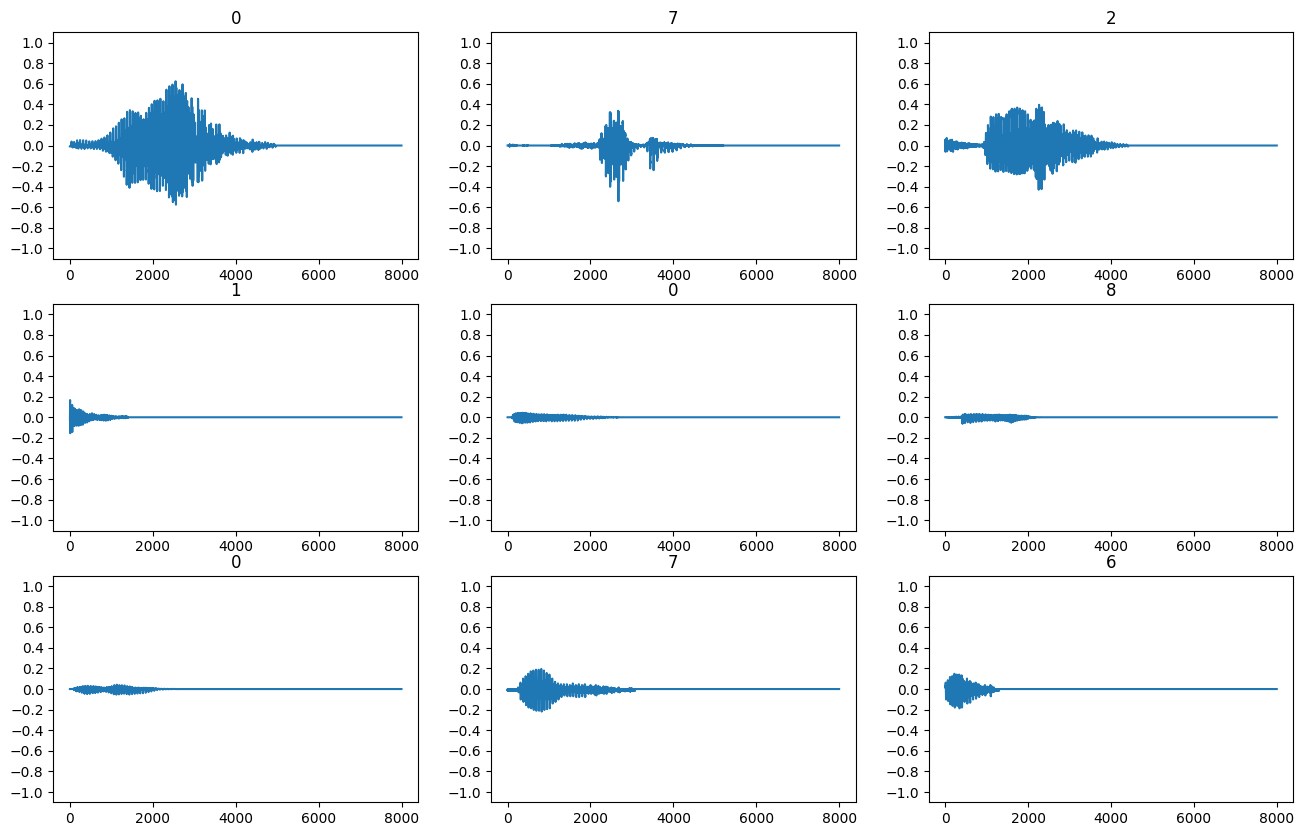

In [ ]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  #audio_signal = example_audio[i]
  audio_signal = example_audio[i].numpy()
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

Utilizamos la Transformada de Furier para convertir la onda de audio en un espectrograma. Es decir, dividimos las ondas de audio en sus componentes frecuenciales

La STFT `tf.signal.stft` divide la señal en ventanas de tiempo y ejecuta una transformada de Fourier en cada ventana, preservando parte de la información temporal, y devolviendo un tensor 2D.

In [ ]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

Mostramos las caracteristicas de algunos ejemplos de la forma de onda tensorizada y el espectrograma correspondiente, y reproducimos el audio original:

In [ ]:
for i in range(3):
  label = label_names[example_labels[i].numpy()]
  #label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=8000))

Label: 0
Waveform shape: (8000,)
Spectrogram shape: (61, 129, 1)
Audio playback


Label: 7
Waveform shape: (8000,)
Spectrogram shape: (61, 129, 1)
Audio playback


Label: 2
Waveform shape: (8000,)
Spectrogram shape: (61, 129, 1)
Audio playback


Definimos una funcion para mostrar el espectograma:

In [ ]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

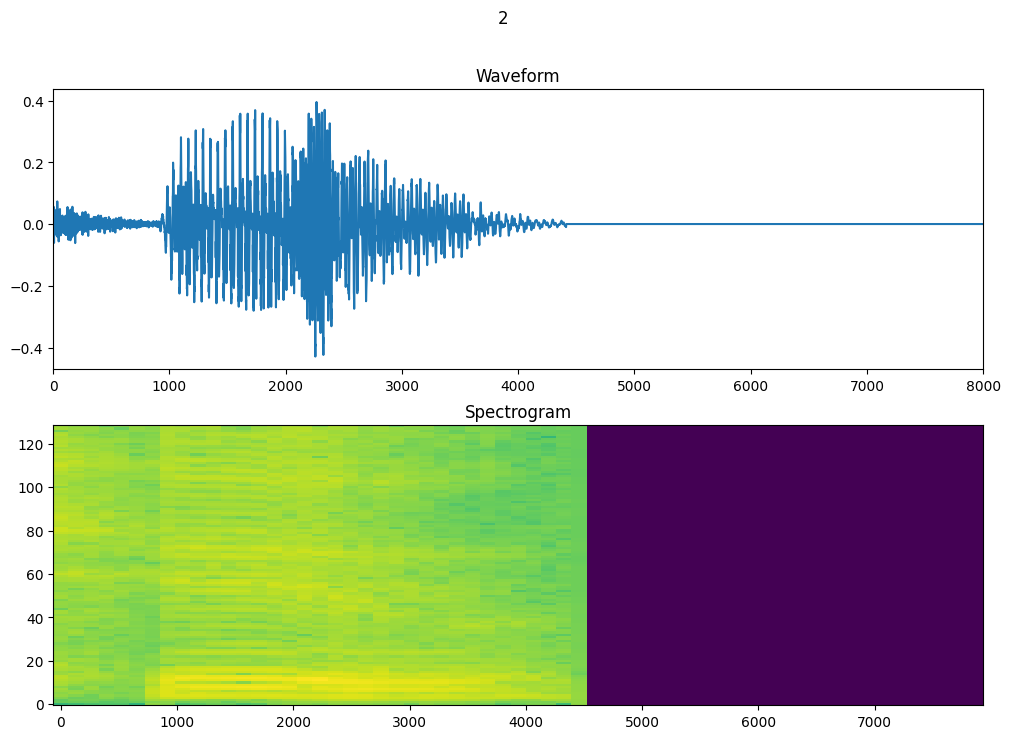

In [ ]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 8000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

Creamos un dataset de espectrogramas utilizando la función definida.

In [ ]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)

Examinamos el espectrograma para distintos ejemplos del dataset.

In [ ]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

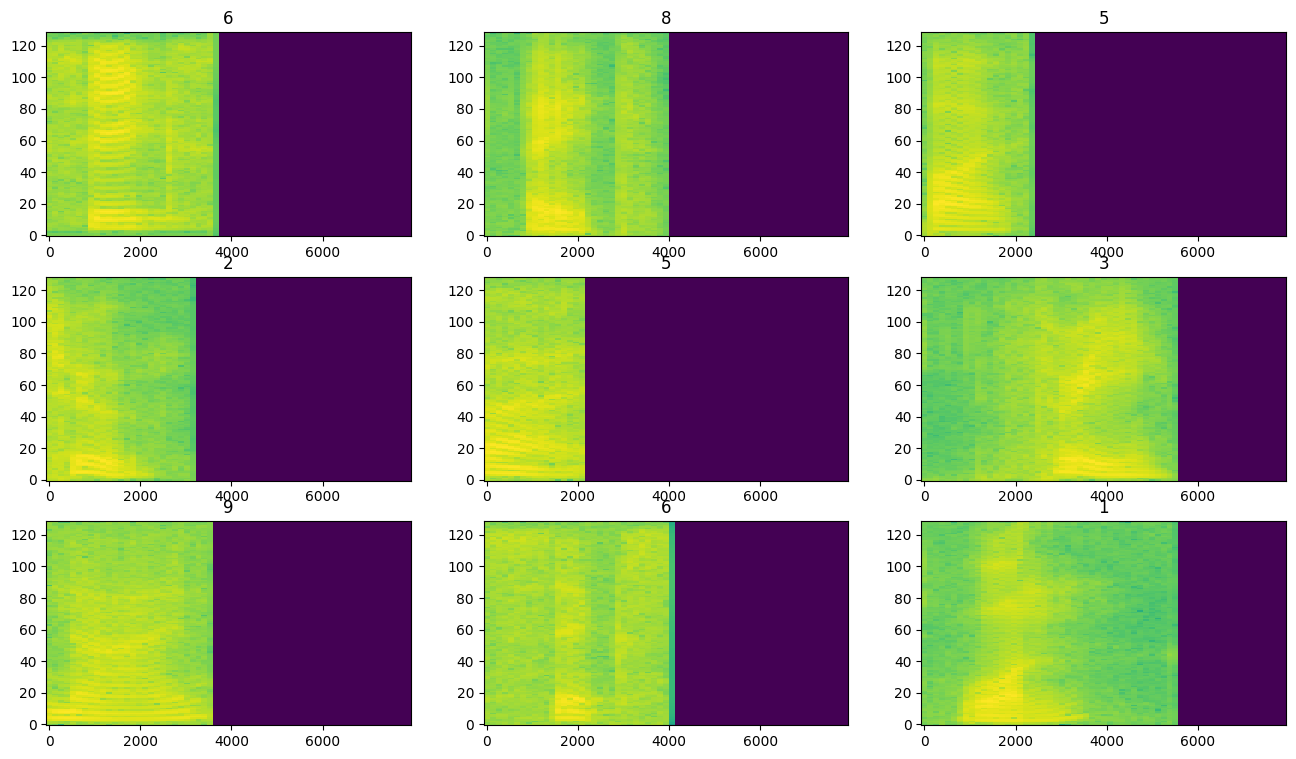

In [ ]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(example_spectrograms[i].numpy(), ax)
  ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

# Construccion y Entrenamiento de modelos

Optimizamos la carga del dataset

In [ ]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

# Modelado CNN

In [ ]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels, activation='softmax'),
])

model.summary()

Input shape: (61, 129, 1)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization (Normalization)   │ (None, 32, 32, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625,869 (6.20 MB)

 Trainable params: 1,625,866 (6.20 MB)

 Non-trainable params: 3 (16.00 B)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
)

Entrenamos durante 50 epocas con un early stopping

In [ ]:
EPOCHS = 50
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=5),
)

Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - accuracy: 0.2939 - loss: 2.0034 - val_accuracy: 0.6783 - val_loss: 1.1887
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5849 - loss: 1.1902 - val_accuracy: 0.7433 - val_loss: 0.8164
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7057 - loss: 0.8822 - val_accuracy: 0.8383 - val_loss: 0.5780
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7842 - loss: 0.6749 - val_accuracy: 0.8600 - val_loss: 0.4798
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8310 - loss: 0.5097 - val_accuracy: 0.9067 - val_loss: 0.3664
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8583 - loss: 0.4353 - val_accuracy: 0.9017 - val_loss: 0.3231
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8773 - loss: 0.3716 - val_accuracy: 0.9183 - val_loss: 0.2726
Epoch 8/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8931 - loss: 0.3139 - val_accuracy: 0.9250 - va

Text(0, 0.5, 'Accuracy [%]')

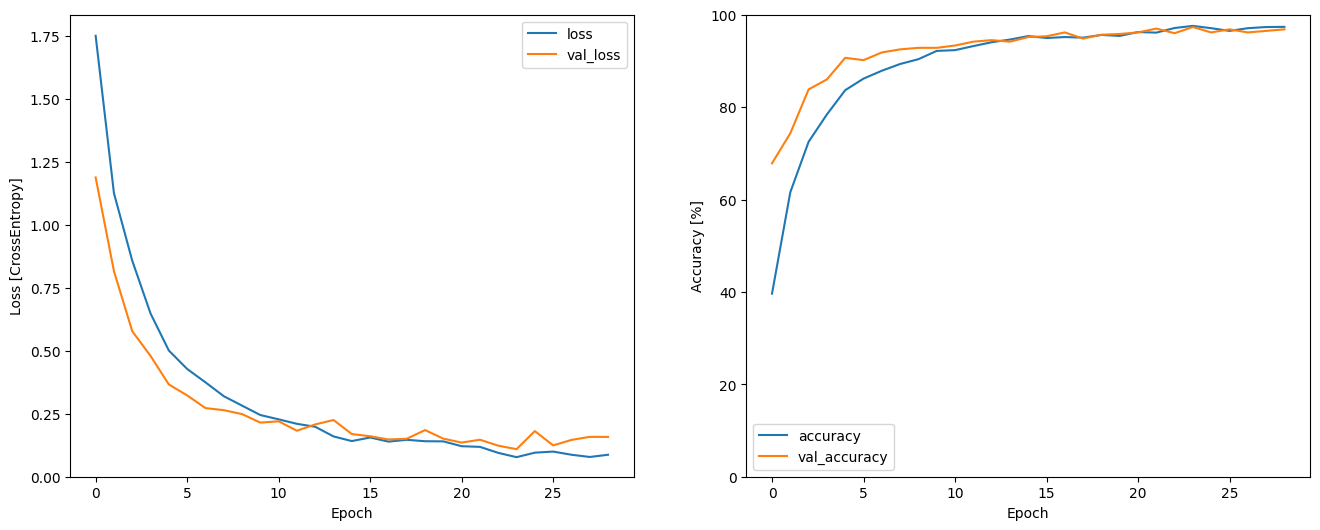

In [ ]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

Observamos que el modelo posee un buen ajuste.

## Matriz de confusion CNN

Realizamos la matriz de confusión para evaluar el desempeño del modelo.

In [ ]:
y_pred = model.predict(val_spectrogram_ds)

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step


In [ ]:
y_pred = tf.argmax(y_pred, axis=1)

In [ ]:
y_true = tf.concat(list(val_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

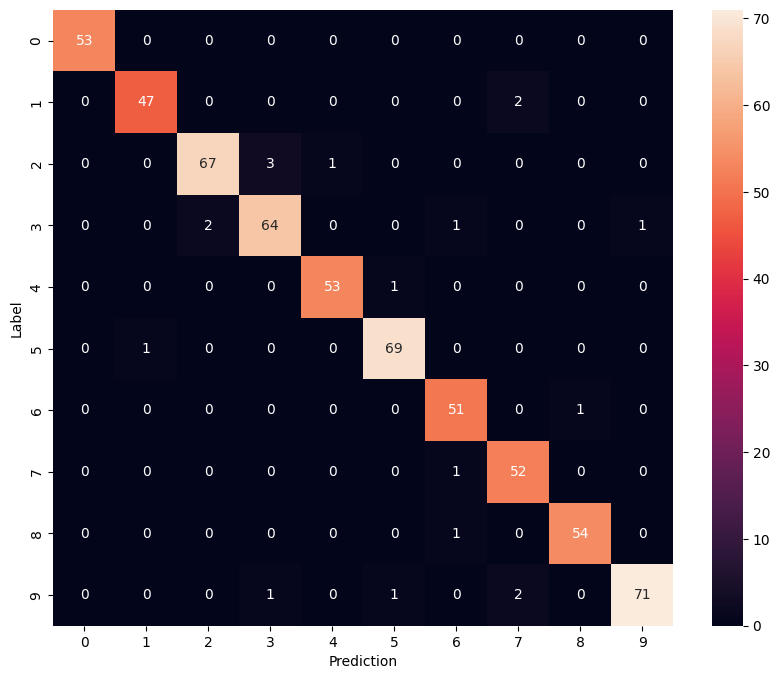

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=label_names, yticklabels=label_names, annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

A partir de la matriz de confusión observamos que el modelo presenta un muy buen desempeño predictivo, ya que la gran mayoría de las instancias fueron correctamente clasificadas. Las clasificaciones incorrectas son muy pocas, lo que indica que el modelo logra distinguir adecuadamente entre las diferentes clases y mantiene un bajo nivel de error.

## Inferencia CNN sobre un archivo de audio

Realizamos inferencia sobre un archivo puntual a modo demostrativo.

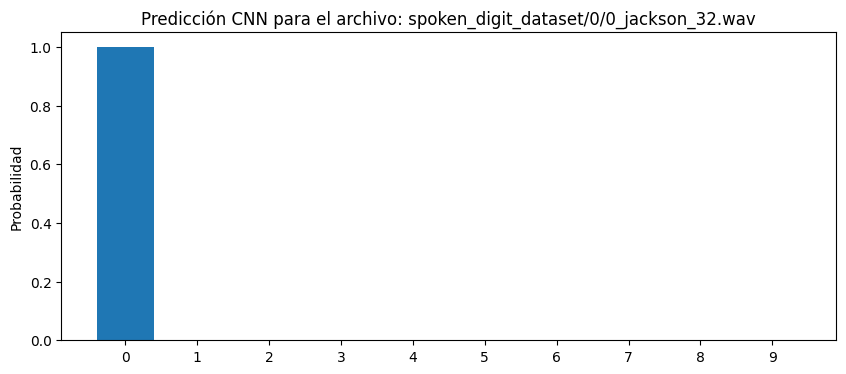

Audio analizado:


In [ ]:
archivo_prueba = "spoken_digit_dataset/0/0_jackson_32.wav"

# Carga y decodificación
x = tf.io.read_file(archivo_prueba)
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=8000)
# ---------------------------

x = tf.squeeze(x, axis=-1) # Quitar dimensión de canal: (8000, 1) -> (8000,)
waveform = x # Guardamos para reproducir

# Convertir a Espectrograma
x = get_spectrogram(x)

# Añadimos dimensión de Batch
# El modelo espera (Batch, Time, Freq, Channel), así que añadimos la primera dimensión
x = x[tf.newaxis, ...]

# Predicción
prediction = model(x)

# Visualización
plt.figure(figsize=(10, 4))
plt.bar(label_names, prediction[0])
plt.title(f'Predicción CNN para el archivo: {archivo_prueba}')
plt.ylabel('Probabilidad')
plt.show()

# Reproducción
print("Audio analizado:")
display.display(display.Audio(waveform, rate=8000))

Notamos que el modelo CNN predice correctamente el numero "0"

# Preprocesamiento Recurrentes

Tomamos la misma funcion `get_spectrogram()`, pero le sacamos un canal:

In [ ]:
def get_spectrogram_rnn(waveform):
  # Convertir a espectrograma (STFT)
  spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)
  spectrogram = tf.abs(spectrogram)

  # NO agregamos tf.newaxis.
  # La forma debe quedar como (Tiempo, Frecuencia).
  # Ejemplo: (61, 129) -> 61 pasos de tiempo, 129 frecuencias por paso.

  return spectrogram

In [ ]:
# Transforma cada ejemplo del dataset aplicando la función get_spectrogram_rnn
# al audio. Devuelve un nuevo dataset donde cada elemento es (espectrograma, label).
# Usa paralelización automática para mejorar el rendimiento.
def make_spec_ds_rnn(ds):
  return ds.map(
    map_func=lambda audio, label: (get_spectrogram_rnn(audio), label),
    num_parallel_calls=tf.data.AUTOTUNE)

Generamos y optimizamos los datasets train_rnn_ds y val_rnn_ds aplicando la función make_spec_ds_rnn, que convierte cada audio en su espectrograma para ser usado por la RNN.

In [ ]:
train_rnn_ds = make_spec_ds_rnn(train_ds)
val_rnn_ds = make_spec_ds_rnn(val_ds)

# Optimización (cache, shuffle, prefetch igual que antes)
train_rnn_ds = train_rnn_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_rnn_ds = val_rnn_ds.cache().prefetch(tf.data.AUTOTUNE)

In [ ]:
# Obtener la forma de entrada. Debería ser (61, 129)
# 61 pasos de tiempo, 129 frecuencias
for example_spectrograms, example_labels in train_rnn_ds.take(1):
  input_shape = example_spectrograms.shape[1:]

print('Input shape:', input_shape) # Esperado: (61, 129)

Input shape: (61, 129)


#Modelado RNN

Se construye un modelo de red neuronal recurrente para clasificar espectrogramas.  Luego se instancia, compila con Adam y se muestra el resumen del modelo.

In [ ]:
def build_lstm_model(num_labels=10):
  inputs = layers.Input(shape=(61, 129))  # (frames, freqs) - Fix freqs dimension

  # Normalización por batch
  x = layers.BatchNormalization()(inputs)

  # LSTM
  x = layers.LSTM(128, return_sequences=True, dropout=0.2)(x)
  x = layers.LSTM(64, dropout=0.2)(x)

  # Clasificación
  outputs = layers.Dense(num_labels, activation="softmax")(x)

  model = models.Model(inputs, outputs)
  return model

model_rnn = build_lstm_model(num_labels=len(label_names))

model_rnn.compile(
  optimizer=tf.keras.optimizers.Adam(1e-3),
  loss="sparse_categorical_crossentropy",
  metrics=["accuracy"],
)

model_rnn.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 61, 129)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 61, 129)        │           516 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 61, 128)        │       132,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 182,670 (713.55 KB)

 Trainable params: 182,412 (712.55 KB)

 Non-trainable params: 258 (1.01 KB)

In [ ]:
history_rnn = model_rnn.fit(
  train_rnn_ds,
  validation_data=val_rnn_ds,
  epochs=40,
  callbacks=tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
)


Epoch 1/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.1088 - loss: 2.3303 - val_accuracy: 0.1133 - val_loss: 2.3104
Epoch 2/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.0963 - loss: 2.3132 - val_accuracy: 0.0950 - val_loss: 2.3027
Epoch 3/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0964 - loss: 2.3003 - val_accuracy: 0.1567 - val_loss: 2.0707
Epoch 4/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.1970 - loss: 2.0595 - val_accuracy: 0.1800 - val_loss: 1.9447
Epoch 5/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.2206 - loss: 1.9075 - val_accuracy: 0.1533 - val_loss: 2.2808
Epoch 6/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.1855 - loss: 2.1222 - val_accuracy: 0.2383 - val_loss: 1.7587
Epoch 7/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.3138 - loss: 1.7550 - val_accuracy: 0.3567 - val_loss: 1.5942
Epoch 8/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4173 - loss: 1.4932 - val_accuracy: 0.4917 - 

Graficamos el loss y el accutacy para los conjuntos de entrenamiento y de validación.

Text(0, 0.5, 'Accuracy [%]')

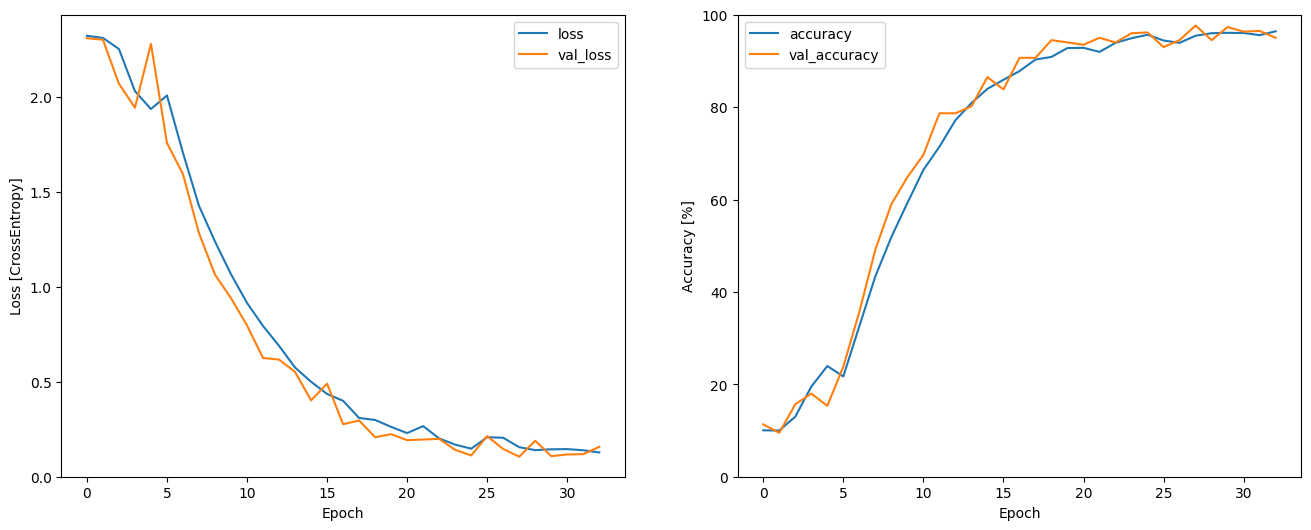

In [ ]:
metrics_rnn = history_rnn.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history_rnn.epoch, metrics_rnn['loss'], metrics_rnn['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history_rnn.epoch, 100*np.array(metrics_rnn['accuracy']), 100*np.array(metrics_rnn['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

Observamos un buen ajuste en el modelo.

## Matriz de confusion RNN

Realizamos la matriz de confusión para evaluar el modelo.

In [ ]:
y_pred_rnn = model_rnn.predict(val_rnn_ds)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


In [ ]:
y_pred_rnn = tf.argmax(y_pred_rnn, axis=1)

In [ ]:
y_true_rnn = tf.concat(list(val_rnn_ds.map(lambda s,lab: lab)), axis=0)

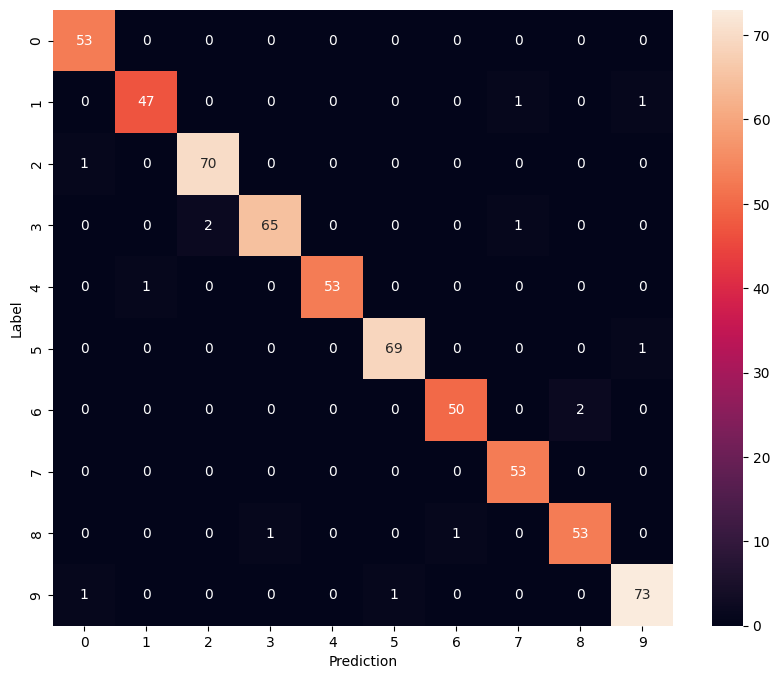

In [ ]:
confusion_mtx_rnn = tf.math.confusion_matrix(y_true_rnn, y_pred_rnn)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx_rnn,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()


La matriz de confusión muestra que el modelo posee una muy buena capacidad predictiva, con un número mínimo de clasificaciones incorrectas, indicando que logró aprender correctamente los patrones del conjunto de datos.

### Inferencia sobre un archivo de audio

Inferimos sobre un archivo arbitrario del dataset.

---



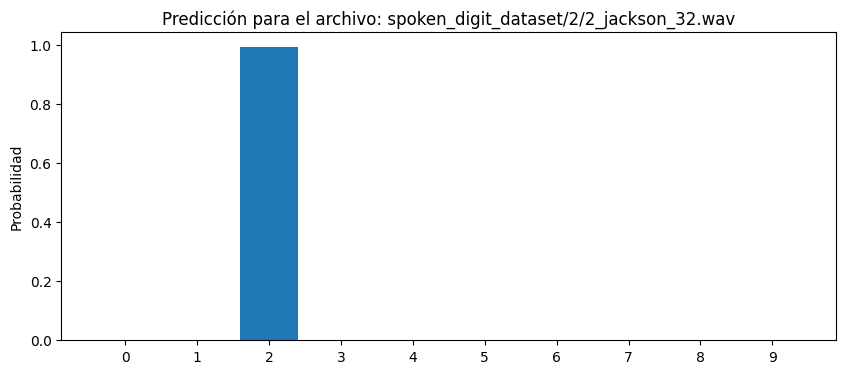

Audio analizado:


In [ ]:
# Archivo del dataset
archivo_prueba = "spoken_digit_dataset/2/2_jackson_32.wav"

# Carga y decodificación
x = tf.io.read_file(archivo_prueba)
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=8000)
# ---------------------------

x = tf.squeeze(x, axis=-1) # Quitar dimensión de canal: (8000, 1) -> (8000,)
waveform = x # Guardamos para reproducir luego

# Convertir a Espectrograma
x = get_spectrogram_rnn(x)

# Añade dimensión de Batch
# El modelo RNN espera (Batch, Time, Features/Freq), es decir (1, 61, 129).
x = x[tf.newaxis, ...]

# Predicción
prediction = model_rnn(x)

# Visualización
plt.figure(figsize=(10, 4))
plt.bar(label_names, prediction[0])
plt.title(f'Predicción para el archivo: {archivo_prueba}')
plt.ylabel('Probabilidad')
plt.show()

# Reproducción
print("Audio analizado:")
display.display(display.Audio(waveform, rate=8000))

Notamos que el modelo de redes recurrentes reconoce correctamente el digito "2" nombrado por el speaker

# Carga de nuevo Dataset de audios

A continuación cargamos un dataset de test con 10 audios (uno para cada dígito) de cada integrante del grupo para
evaluar el modelo sobre el mismo.

In [ ]:
url_data = "https://github.com/guillericci/AA2-TP2-P1-CICORIA-RICCI/tree/main/dataset_test"

repo_url = "https://github.com/guillericci/AA2-TP2-P1-CICORIA-RICCI.git"
repo_name = "AA2-TP2-P1-CICORIA-RICCI"

if not os.path.exists(repo_name):
  print("Clonando dataset de test...")
  !git clone {repo_url}
else:
  print("El repo ya existe. Si quieres actualizarlo, borra la carpeta y vuelve a clonar.")

# Ruta a la carpeta que contiene las subcarpetas (0, 1, 2...)
test_data_dir = pathlib.Path(f"{repo_name}/dataset_test")

print(f"Ruta de test configurada: {test_data_dir}")

Clonando dataset de test...
Cloning into 'AA2-TP2-P1-CICORIA-RICCI'...
remote: Enumerating objects: 82, done.
remote: Counting objects: 100% (82/82), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 82 (delta 1), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (82/82), 369.99 KiB | 10.88 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Ruta de test configurada: AA2-TP2-P1-CICORIA-RICCI/dataset_test


Creamos el dataset de prueba sin mezcla de datos, manteniendo la misma longitud de audio que en el entrenamiento. Luego se extraemos y mostramos los nombres de las clases para asegurarnos que coincidan con las utilizadas durante el entrenamiento.

In [ ]:
test_grab = tf.keras.utils.audio_dataset_from_directory(
  test_data_dir,
  batch_size=32,
  validation_split=None, # Usamos todo para test
  shuffle=False,         # No mezclamos para mantener orden
  seed=42,
  output_sequence_length=8000 # igual al de entrenamiento
)

# Obtener los nombres de las clases (asegura que coincidan con label_names del entrenamiento)
test_label_names = np.array(test_grab.class_names)
print("Clases en el test set:", test_label_names)

Found 20 files belonging to 10 classes.
Clases en el test set: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


## Evaluacion con modelo CNN

Inferimos sobre un audio aleatorio del dataset para evaluar el desempeño del modelo CNN.

tf.Tensor(8000, shape=(), dtype=int32)


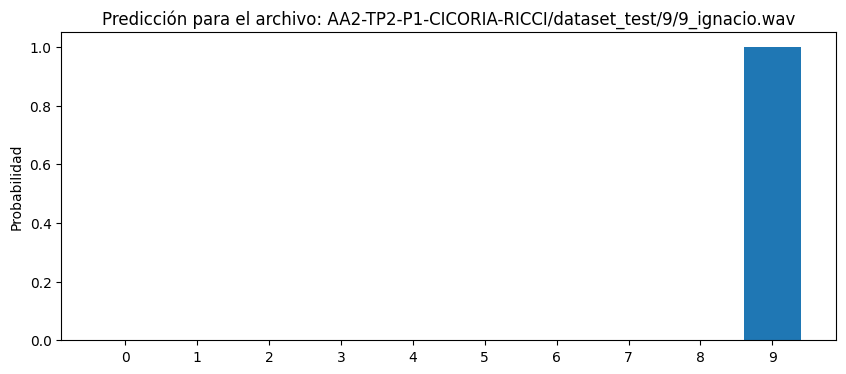

Audio analizado:


In [ ]:
# Archivo de prueba del dataset
archivo_prueba = "AA2-TP2-P1-CICORIA-RICCI/dataset_test/9/9_ignacio.wav"

# Carga y decodificación
x = tf.io.read_file(archivo_prueba)
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=8000)
print(sample_rate)
# ---------------------------

x = tf.squeeze(x, axis=-1) # Quitamos dimensión de canal: (8000, 1) -> (8000,)
waveform = x # Guardamos para reproducir

# Convierte a Espectrograma
x = get_spectrogram(x)

# Añade dimensión de Batch
# El modelo espera (Batch, Time, Freq, Channel), así que añadimos la primera dimensión
x = x[tf.newaxis, ...]

# Predicción
prediction = model(x)

# Visualización
plt.figure(figsize=(10, 4))
plt.bar(label_names, prediction[0])
plt.title(f'Predicción para el archivo: {archivo_prueba}')
plt.ylabel('Probabilidad')
plt.show()

# Reproducción
print("Audio analizado:")
display.display(display.Audio(waveform, rate=8000))

## Evaluacion del modelo RNN

Inferimos sobre un audio aleatorio del dataset para evaluar el desempeño del modelo RNN.

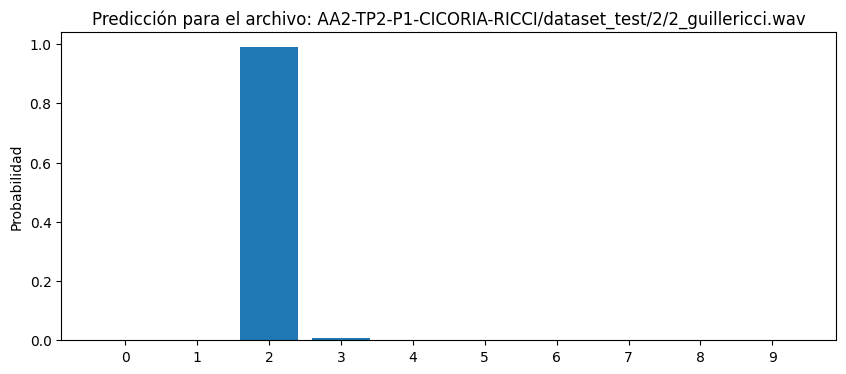

Audio analizado:


In [ ]:
# Archivo de prueba del dataset
archivo_prueba = "AA2-TP2-P1-CICORIA-RICCI/dataset_test/2/2_guillericci.wav"

# Carga y decodificación
x = tf.io.read_file(archivo_prueba)
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=8000)
# ---------------------------

x = tf.squeeze(x, axis=-1) # Quitar dimensión de canal: (8000, 1) -> (8000,)
waveform = x # Guardamos para reproducir luego

# Conversion a Espectrograma
x = get_spectrogram_rnn(x)

# Añade dimensión de Batch
# El modelo RNN espera (Batch, Time, Features/Freq), es decir (1, 61, 129).
x = x[tf.newaxis, ...]

# Predicción
prediction = model_rnn(x)

# Visualización
plt.figure(figsize=(10, 4))
plt.bar(label_names, prediction[0])
plt.title(f'Predicción para el archivo: {archivo_prueba}')
plt.ylabel('Probabilidad')
plt.show()

# Reproducción
print("Audio analizado:")
display.display(display.Audio(waveform, rate=8000))

Elgimos el modelo de RNN para realizar una prediccion sobre todo el dataset

In [ ]:
# -------------------------------------------
#  CONFIG: ruta del dataset de prueba
# -------------------------------------------
test_data_dir = "AA2-TP2-P1-CICORIA-RICCI/dataset_test"

# Obtener lista de carpetas ordenadas (clases 0–9)
clases = sorted(os.listdir(test_data_dir))
print("Clases detectadas:", clases)

# Función: preprocesar + predecir un archivo WAV
def predecir_archivo(ruta, model, get_spectrogram_fn, label_names):
  # Leer archivo
  x = tf.io.read_file(ruta)
  x, sr = tf.audio.decode_wav(
    x,
    desired_channels=1,
    desired_samples=8000
  )

  # Guardar para reproducción
  waveform = tf.squeeze(x, axis=-1)

  # Transformar a espectrograma
  spec = get_spectrogram_fn(waveform)

  # Expandir dimensión batch
  spec = spec[tf.newaxis, ...]

  # Predicción
  pred = model(spec)
  probs = tf.nn.softmax(pred[0]).numpy()
  pred_label = label_names[np.argmax(probs)]

  return probs, pred_label, waveform, sr

# -------------------------------------------
#  LOOP SOBRE TODOS LOS ARCHIVOS
# -------------------------------------------
resultados = []

for clase in clases:
  carpeta = os.path.join(test_data_dir, clase)
  archivos = os.listdir(carpeta)
  ultimo_prefijo = None
  for archivo in archivos:
    ruta = os.path.join(carpeta, archivo)

    probs, pred_label, waveform, sr = predecir_archivo(
      ruta,
      model_rnn,               # modelo CNN o RNN
      get_spectrogram_rnn,     # espectrograma
      label_names          # nombres de clases del entrenamiento
    )


    resultados.append((int(clase), archivo, pred_label))
    prefijo = archivo.split("_")[0]
    if prefijo != ultimo_prefijo:
      print()
      ultimo_prefijo = prefijo
    print(f"Archivo: {archivo} | Real: {clase} | Predicho: {pred_label}")
# -------------------------------------------
#  Mostrar resumen final
# -------------------------------------------
print("\nRESULTADOS FINALES:")
correctos = sum(1 for real, archivo, pred in resultados if str(real) == pred)
total = len(resultados)

print(f"Accuracy en las grabaciones: {correctos}/{total}  ({100*correctos/total:.2f}%)")


Clases detectadas: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

Archivo: 0_ignacio.wav | Real: 0 | Predicho: 0
Archivo: 0_guillericci.wav | Real: 0 | Predicho: 0

Archivo: 1_ignacio.wav | Real: 1 | Predicho: 1
Archivo: 1_guillericci.wav | Real: 1 | Predicho: 1

Archivo: 2_guillericci.wav | Real: 2 | Predicho: 2
Archivo: 2_ignacio.wav | Real: 2 | Predicho: 2

Archivo: 3_ignacio.wav | Real: 3 | Predicho: 3
Archivo: 3_guillericci.wav | Real: 3 | Predicho: 3

Archivo: 4_guillericci.wav | Real: 4 | Predicho: 9
Archivo: 4_ignacio.wav | Real: 4 | Predicho: 4

Archivo: 5_ignacio.wav | Real: 5 | Predicho: 5
Archivo: 5_guillericci.wav | Real: 5 | Predicho: 9

Archivo: 6_guillericci.wav | Real: 6 | Predicho: 3
Archivo: 6_ignacio.wav | Real: 6 | Predicho: 6

Archivo: 7_ignacio.wav | Real: 7 | Predicho: 7
Archivo: 7_guillericci.wav | Real: 7 | Predicho: 9

Archivo: 8_ignacio.wav | Real: 8 | Predicho: 8
Archivo: 8_guillericci.wav | Real: 8 | Predicho: 3

Archivo: 9_ignacio.wav | Real: 9 | Pre

Teniendo en cuenta que los audios de prueba fueron grabados en condiciones distintas a las del conjunto de entrenamiento, y considerando además las variaciones propias de la pronunciación en una lengua extranjera, el modelo logra mantener un buen desempeño, alcanzando un 75% de exactitud en grabaciones reales. Esto indica que el modelo generaliza razonablemente bien fuera de las condiciones controladas del dataset original.

# Detalle del proceso de grabación

Antes de registrar los audios de prueba, analizamos visualmente los espectrogramas del dataset de entrenamiento. A partir de esta comparación observamos que era necesario aumentar la ganancia de grabación para aproximarla a la del audio original. Además, intentamos que la ecualización de las nuevas grabaciones fueran lo más similares posible a las del dataset utilizado para entrenar el modelo.

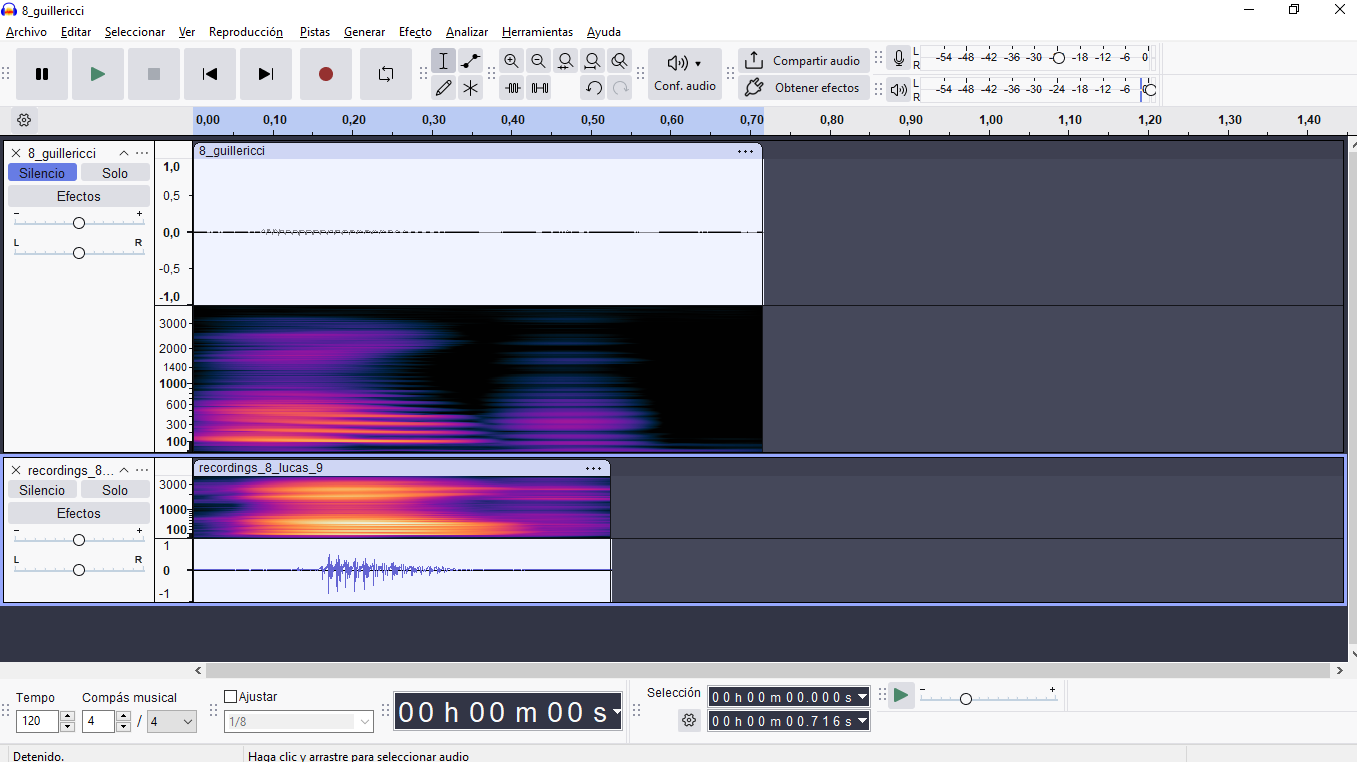